In [1]:
!pip install --no-index -U --find-links=/kaggle/input/deeptables-dependecies deeptables==0.2.5

Looking in links: /kaggle/input/deeptables-dependecies
Processing /kaggle/input/deeptables-dependecies/deeptables-0.2.5-py3-none-any.whl
Processing /kaggle/input/deeptables-dependecies/hypernets-0.3.1-py3-none-any.whl (from deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/XlsxWriter-3.1.9-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/paramiko-3.4.0-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/bcrypt-4.1.2-cp39-abi3-manylinux_2_28_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)


In [2]:
import warnings

warnings.filterwarnings("ignore")

import os
import gc
import pickle
import datetime

import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px
import joblib
from sklearn.ensemble import VotingRegressor
import lightgbm as lgb
from joblib import load

import holidays

import warnings
warnings.filterwarnings("ignore")
import math
import ctypes

import random
import matplotlib.pyplot as plt

import tensorflow as tf, deeptables as dt
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.python.keras import backend as K
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets

print('TensorFlow version:',tf.__version__)
print('DeepTables version:',dt.__version__)

TensorFlow version: 2.13.0
DeepTables version: 0.2.5


> <h4> This is a bonus version of this Notebook, since I have exhausted my entire GPU quota for the week 🙃. 
Here, I have tried to ensemble the predictions of two trained models. But the catch is that both were trained on datasets having different number of features. I have tried to explore the implications of this difference on the end predictions. 

> <h4> I will be using a trained model which I published earlier as a dataset. It had an independent MAE of 65.51 on the public test set (LeaderBoard) and the other model will be the one which we trained on Version 1[(see here)](https://www.kaggle.com/code/siddhvr/enefit-pebop-eda-plotly-and-modelling) of this notebook.

In [3]:
train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
gas_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv')
electricity_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv')
client_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv')
fw_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv')
hw_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv')
locations = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv')

In [4]:
tmp_df = train.copy()
tmp_df['datetime'] = pd.to_datetime(tmp_df['datetime'], utc=True)
#Adding hour column in train data
tmp_df['hour'] = tmp_df['datetime'].dt.hour
#Adding dayofweek column in train data
tmp_df['dayofweek'] = tmp_df['datetime'].dt.dayofweek
tmp_df = tmp_df[tmp_df['target'] >= 2]

skewness_dayofweek_dict = tmp_df.groupby(['county', 'is_business', 'product_type', "is_consumption", 'dayofweek'])['target'].skew().to_dict()
skewness_dayofweek_dict = {(str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '_' + str(key[3]) + '_' + str(key[4])): val for key, val in skewness_dayofweek_dict.items()}

kurtosis_dayofweek_dict = tmp_df.groupby(['county', 'is_business', 'product_type', "is_consumption", 'dayofweek'])['target'].apply(pd.Series.kurt).to_dict()
kurtosis_dayofweek_dict = {(str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '_' + str(key[3]) + '_' + str(key[4])): val for key, val in kurtosis_dayofweek_dict.items()}

skewness_hour_dict = tmp_df.groupby(['county', 'is_business', 'product_type', "is_consumption", 'hour'])['target'].skew().to_dict()
skewness_hour_dict = {(str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '_' + str(key[3]) + '_' + str(key[4])): val for key, val in skewness_hour_dict.items()}

kurtosis_hour_dict = tmp_df.groupby(['county', 'is_business', 'product_type', "is_consumption", 'hour'])['target'].apply(pd.Series.kurt).to_dict()
kurtosis_hour_dict = {(str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '_' + str(key[3]) + '_' + str(key[4])): val for key, val in kurtosis_hour_dict.items()}

grouped_median = tmp_df.groupby(['county', 'is_business', 'product_type', "is_consumption", 'dayofweek'])['target'].median()
total_median = grouped_median.groupby(['county', 'is_business', 'product_type', "is_consumption"]).sum()
proportion_median = (grouped_median/ total_median).fillna(1/7).to_dict()
proportion_median_dict = {(str(key[0]) + '_' + str(key[1]) + '_' + str(key[2]) + '_' + str(key[3]) + '_' + str(key[4])): val for key, val in proportion_median.items()}

# percentile_05 = tmp_df.groupby(['is_consumption', 'prediction_unit_id'])['target'].quantile(0.05).to_dict() 
# percentile_05_dict = {(str(key[0]) + '_' + str(key[1])): val for key, val in percentile_05.items()}
# percentile_95 = tmp_df.groupby(['is_consumption', 'prediction_unit_id'])['target'].quantile(0.95).to_dict() 
# percentile_95_dict = {(str(key[0]) + '_' + str(key[1])): val for key, val in percentile_95.items()}


In [5]:
tmp_df = gas_df.copy()
tmp_df['day'] = pd.to_datetime(tmp_df['forecast_date']).dt.day.astype(int)
tmp_df['month'] = pd.to_datetime(tmp_df['forecast_date']).dt.month.astype(int)
tmp_df['dayofweek'] = pd.to_datetime(tmp_df['forecast_date']).dt.dayofweek.astype(int)

gas_dict_uq = tmp_df.groupby('month')['highest_price_per_mwh'].quantile(0.75).to_dict()

tmp_df = electricity_df.copy()
tmp_df['hour'] = pd.to_datetime(tmp_df['forecast_date']).dt.hour.astype(int)

electricity_uq = tmp_df.groupby('hour')['euros_per_mwh'].quantile(0.75).to_dict()

In [6]:
def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
clean_memory()

### Step 1 : Create a class to access and process all the data files

In [7]:
class DataStorage:
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    
    gas_prices_cols = [
        "forecast_date", 
        "lowest_price_per_mwh",
        "highest_price_per_mwh"
    ]
    
    electricity_prices_cols = [
        "forecast_date", 
        "euros_per_mwh"
    ]
    
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    
    location_cols = ["longitude", "latitude", "county"]
    
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test


### Step 2: Create Feature Enegineering Classes

> <h4> For ease of understanding and clarity, I will be using two different feature engineering classes for both models. However, we can also merge them and make a single class since, most of the functions are the same with minor changes elsewhere. But remember to have two different <i>'generate_features'</i> functions for both of these in that case.

In [8]:
class FeatureEngineer:
    def __init__(self, data):
        self.data = data
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(pl.concat_str("county","is_business","product_type","is_consumption",separator="_",).alias("segment"),)
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
                (np.pi * np.sin(pl.col("dayofyear")) / 183).alias("sin(dayofyear2)"),
                (np.pi * np.cos(pl.col("dayofyear")) / 183).alias("cos(dayofyear2)"),
                (np.pi * np.sin(pl.col("hour")) / 12).alias("sin(hour2)"),
                (np.pi * np.cos(pl.col("hour")) / 12).alias("cos(hour2)")
            )
        )
        return df_features

    def _client_features(self, df_features):
        df_client = self.data.df_client

        df_features = df_features.join(
            df_client.with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),on=["county", "is_business", "product_type", "date"],how="left",
        )
        
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )
    
    def is_weekend(self, row):
        return (
            row['weekday'] == 5 or row['weekday'] == 6
        )
    
    def _holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        
        df_features = df_features.with_columns(
            pl.struct(['weekday'])
            .apply(self.is_weekend)
            .alias('is_weekend')
        )
        return df_features

    def _forecast_weather_features(self, df_features):
        df_forecast_weather = self.data.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
#             .drop("hours_ahead")
            .with_columns(pl.col("latitude").cast(pl.datatypes.Float32),pl.col("longitude").cast(pl.datatypes.Float32),)
            .join(df_weather_station_to_county_mapping,how="left",on=["longitude", "latitude"],).drop("longitude", "latitude"))

        df_forecast_weather_date = (df_forecast_weather.group_by("datetime").mean().drop("county"))

        df_forecast_weather_local = (df_forecast_weather.filter(pl.col("county").is_not_null()).group_by("county", "datetime").mean())

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),on="datetime",how="left",suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),on=["county", "datetime"],how="left",suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _historical_weather_features(self, df_features):
        df_historical_weather = self.data.df_historical_weather
        df_weather_station_to_county_mapping = (self.data.df_weather_station_to_county_mapping)

        df_historical_weather = (
            df_historical_weather.with_columns(pl.col("latitude").cast(pl.datatypes.Float32),pl.col("longitude").cast(pl.datatypes.Float32),
            ).join(df_weather_station_to_county_mapping,how="left",on=["longitude", "latitude"],).drop("longitude", "latitude")
        )

        df_historical_weather_date = (df_historical_weather.group_by("datetime").mean().drop("county"))

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null()).group_by("county", "datetime").mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),on="datetime",how="left",suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),on=["county", "datetime"],how="left",suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),).filter(pl.col("hour") <= 10).drop("hour"),on="datetime",how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features
    
    def _gas_price_features(self, df_features):
        
        df_gas_price = self.data.df_gas_prices
        df_electricity = self.data.df_electricity_prices
        
        df_gas_price = df_gas_price.with_columns(
            pl.col("forecast_date").cast(pl.Date).dt.year().alias("year"),
            pl.col("forecast_date").cast(pl.Date).dt.month().alias("month"),
            pl.col("forecast_date").cast(pl.Date).dt.day().alias("day")
        )
        
        df_gas_price = df_gas_price.drop("forecast_date")
        
        df_features = df_features.join(
            df_gas_price.with_columns(
                pl.col("lowest_price_per_mwh"),
                pl.col("highest_price_per_mwh")
            ), 
            on = ["year", "month", "day"], 
            how = "left"
        )
        
        
        return df_features
    
    def _target_features(self, df_features):
        df_target = self.data.df_target

        df_target_all_type_sum = (df_target.group_by(["datetime", "county", "is_business", "is_consumption"]).sum().drop("product_type"))

        df_target_all_county_type_sum = (df_target.group_by(["datetime", "is_business", "is_consumption"]).sum().drop("product_type", "county"))
        
        hours_list=[i*24 for i in range(2,15)]

        for hours_lag in hours_list:
            df_features = df_features.join(
                df_target.with_columns(pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=["county","is_business","product_type","is_consumption","datetime",],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(pl.col("datetime") + pl.duration(hours=hours_lag)).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [f"target_{hours_lag}h" for hours_lag in hours_list[:4]]
        
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats).transpose().std().transpose().to_series().alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14), 
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10), 
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (pl.col(f"{target_prefix}_{lag_nominator}h")/ (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop("datetime", "dayofyear")
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = ["county","is_business","product_type","is_consumption","segment",]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")
    
        return df_features
    
    # added some new features here
    def _additional_features(self, df):
        for col in [
                    'temperature', 
                    'dewpoint', 
                    '10_metre_u_wind_component', 
                    '10_metre_v_wind_component', 
            ]:
            for window in [1]:
                df[f"{col}_diff_{window}"] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business'])[col].diff(window)
        
        # Skewness & Kurtosis 
        df['update_weekday'] = df['segment'].astype(str) + "_" + df['weekday'].astype(str)
        df['update_hour'] = df['segment'].astype(str) + "_" + df['hour'].astype(str)
        
        df['skewness_dayofweek'] = df['update_weekday'].map(skewness_dayofweek_dict)
        df['kurtosis_dayofweek'] = df['update_weekday'].map(kurtosis_dayofweek_dict)
        df['proportion_median'] = df['update_weekday'].map(proportion_median_dict)
        
        df['skewness_hour'] = df['update_hour'].map(skewness_hour_dict)
        df = df.drop(columns = ['update_weekday', 'update_hour'])
        
        # Target Features Expansion
        tgt_lag_columns = ['target_48h', 'target_72h', 'target_96h', 'target_120h', 'target_144h', 'target_168h']
        
        from itertools import combinations
        for c in combinations(tgt_lag_columns, 2):
            # Imbalanced Features
            df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")
        
        for m in ['var', "skew", "kurt"]:
            df[f'target_{m}'] = df[tgt_lag_columns].agg(m, axis=1)
        
        # Gas & Electricity Features
        df['gas_price_level_uq'] = (df['month'].map(gas_dict_uq) / df['lowest_price_per_mwh']).astype('float32')
        
        # adding new feature
        df['new_feature'] = (df['installed_capacity'] * df['surface_solar_radiation_downwards']) / (df['temperature'] + 273.15)
        
        # Calculate wind speed
        df['wind_speed'] = np.sqrt(df['10_metre_u_wind_component']**2 + df['10_metre_v_wind_component']**2)

        # Calculate wind direction in degrees
        df['wind_direction'] = np.degrees(np.arctan2(df['10_metre_v_wind_component'], df['10_metre_u_wind_component']))
        
        # Calculate weather interactions 
        df['humidity'] = df['temperature'] - df['dewpoint']
        
        # Solar Radiation
        df['radiation_cloud_interaction'] = df['surface_solar_radiation_downwards'] * (1 - df['cloudcover_total'] / 100)
        df['radiation_cloud_interaction_2'] = df['direct_solar_radiation'] * (1 - df['cloudcover_total'] / 100)
        df['direct_diffuse_radiation_ratio'] = df['direct_solar_radiation'] / (df['surface_solar_radiation_downwards'] + 1e-5)
        
        diff_cols = [
            ['temperature', 'temperature_forecast_local_0h'],
            ['dewpoint', 'dewpoint_forecast_local_0h'],
            ['cloudcover_total', 'cloudcover_total_forecast_local_0h'],
            ['direct_solar_radiation', 'direct_solar_radiation_forecast_local_0h'],
            ['surface_solar_radiation_downwards', 'surface_solar_radiation_downwards_forecast_local_0h'],
            ['lowest_price_per_mwh', 'highest_price_per_mwh']
        ]

        for c in diff_cols:
            df[f"{c[0]}_{c[1]}_imb"] = (df[c[0]] - df[c[1]]) / (df[c[0]] + df[c[1]] + 1e-7)

        return df
    
    def _log_outliers(self,df):
        l1 = ['installed_capacity', 'target_mean', 'target_std']
        for i in l1:
            df = df.with_columns([(f"log_{i}", pl.when(df[i] != 0).then(np.log(pl.col(i))).otherwise(0))])
        return df
        

    def generate_features(self, df_prediction_items,isTrain):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._general_features,
            self._client_features,
            self._forecast_weather_features,
            self._historical_weather_features,
            self._gas_price_features,
            self._target_features,
            self._holidays_features,
            self._log_outliers,
            self._reduce_memory_usage,
            self._drop_columns,]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)
        df_features = self._additional_features(df_features)
        df_features[['eic_count', 'skewness_dayofweek', 'kurtosis_dayofweek', 'proportion_median', 'skewness_hour']] = df_features[['eic_count', 'skewness_dayofweek', 'kurtosis_dayofweek', 'proportion_median', 'skewness_hour']].astype('float32')
        return df_features

In [9]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [2 * 24,3 * 24,4 * 24,5 * 24,6 * 24,7 * 24,8 * 24,9 * 24,10 * 24,11 * 24,12 * 24,13 * 24,14 * 24,]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=["county","is_business","product_type","is_consumption","datetime",],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )
        

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features
    
    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_holidays_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

# Initialisation

In [10]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)
feat_gen = FeatureEngineer(data=data_storage)

### Feature Generation

> <h5>Although there is no requirement as such to create the training datasets, (since we are not doing any model training here) I have created them only to show the difference in the features between the two datasets we are using here

In [11]:
df_train_features = features_generator.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

In [12]:
df_train = feat_gen.generate_features(data_storage.df_data, True)
df_train = df_train[df_train['target'].notnull()]

Learning rate schedule: 1e-07 to 0.001 to 1e-07


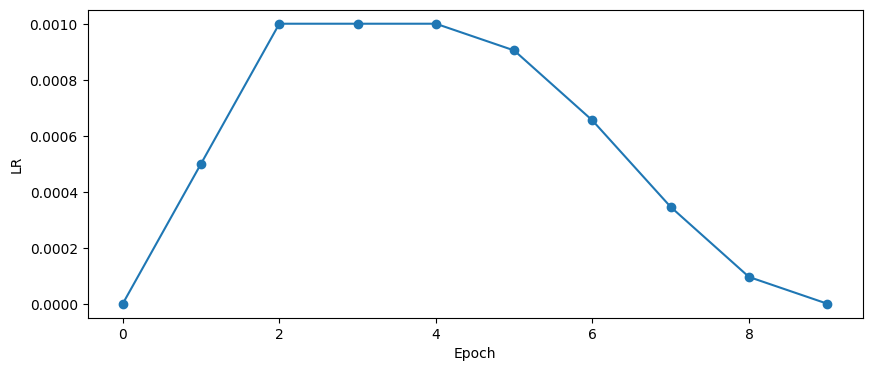

In [13]:
LR_START = 1e-7
LR_MAX = 1e-3
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 2
EPOCHS = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
        
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

- About Training the Model

nn = True
lgb = False

 nn model consumption training. 

01-31 13:22:03 I deeptables.m.deeptable.py 338 - X.Shape=(825951, 219), y.Shape=(825951,), batch_size=512, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns=['county', 'is_business', 'product_type', 'is_consumption', 'segment', 'is_country_holiday', 'is_weekend'], exclude_columns=[], task='regression', pos_label=None, metrics='MeanAbsoluteError', auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=False, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=False, apply_class_weight=False, optimizer=<tensorflow_addons.optimizers.weight_decay_optimizers.AdamW object at 0

01-31 13:22:06 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-31 13:22:06 I deeptables.m.preprocessor.py 261 - Preparing features...
01-31 13:22:06 I deeptables.m.preprocessor.py 311 - Column [date] has been discarded. It is not numeric and not in [config.categorical_columns].
01-31 13:22:09 I deeptables.m.preprocessor.py 336 - Preparing features taken 2.27787184715271s
01-31 13:22:09 I deeptables.m.preprocessor.py 341 - Data imputation...
01-31 13:22:16 I deeptables.m.preprocessor.py 383 - Imputation taken 7.621931076049805s
01-31 13:22:16 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-31 13:22:16 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.21607422828674316s
01-31 13:22:16 I deeptables.m.preprocessor.py 398 - Data discretization...
01-31 13:22:16 I hypernets.t.sklearn_ex.py 716 - 210 variables to discrete.
01-31 13:22:27 I deeptables.m.preprocessor.py 404 - Discretization taken 10.17914891242981s
01-31 13:22:30 I deeptables.m.preprocessor.py 196 - fit_transform taken 24.769487380981445s
01-31 13:22:30 I

01-31 13:31:26 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-31 13:31:27 I deeptables.m.preprocessor.py 261 - Preparing features...
01-31 13:31:27 I deeptables.m.preprocessor.py 311 - Column [date] has been discarded. It is not numeric and not in [config.categorical_columns].
01-31 13:31:29 I deeptables.m.preprocessor.py 336 - Preparing features taken 2.032928228378296s
01-31 13:31:29 I deeptables.m.preprocessor.py 341 - Data imputation...
01-31 13:31:36 I deeptables.m.preprocessor.py 383 - Imputation taken 7.532551050186157s
01-31 13:31:36 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-31 13:31:37 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.22050881385803223s
01-31 13:31:37 I deeptables.m.preprocessor.py 398 - Data discretization...
01-31 13:31:37 I hypernets.t.sklearn_ex.py 716 - 210 variables to discrete.
01-31 13:31:46 I deeptables.m.preprocessor.py 404 - Discretization taken 8.857323408126831s
01-31 13:31:49 I deeptables.m.preprocessor.py 196 - fit_transform taken 22.167980670928955s
01-31 13:31:49 

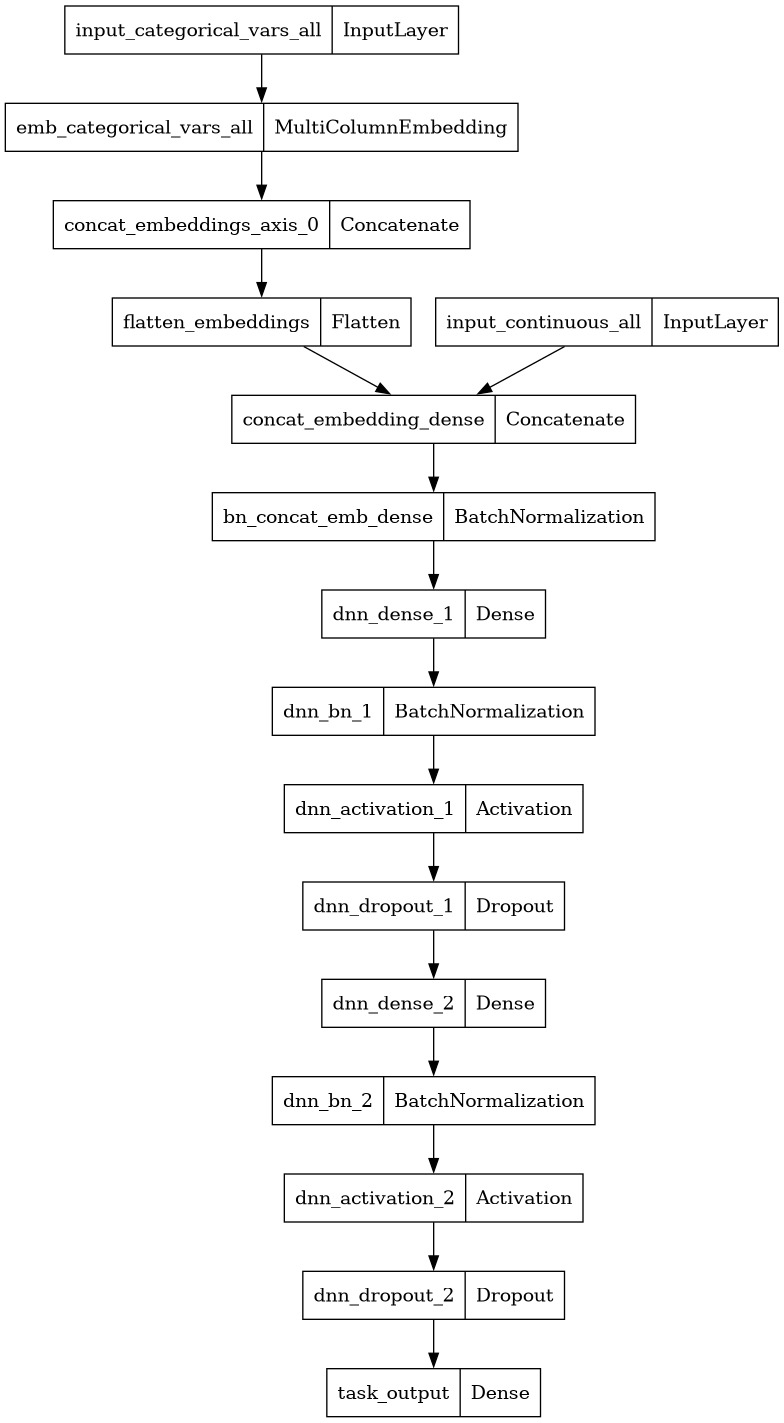

In [14]:
%%time
class CFG:
    nn = True
    lgb = False
    ens_weights = {'nn': 0.5, 'lgb': 0.5}
    epochs = 10
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = []  # [LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)
     
class Model:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns=['county', 'is_business', 'product_type', 'is_consumption', 'segment','is_country_holiday', 'is_weekend'],
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                   'hidden_units': ((512, 0.3, True),
                                                    (256, 0.3, True)),
                                   'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                            )
        
        self.lgb_params = {"n_estimators": 2500,
                           "learning_rate": 0.06,
                           "max_depth": 16,
                           "num_leaves": 500,
                           "reg_alpha": 3.5,
                           "reg_lambda": 1.5,
                           "colsample_bytree": 0.9,
                           "colsample_bynode": 0.6,
                           "min_child_samples": 50,
                           "random_state": 0,
                           "objective": "regression_l1",
                           "device": "gpu",
                           "n_jobs": 4,
                           "verbose": -1,
                           }
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)
        
        self.lgb_model_consumption = lgb.LGBMRegressor(**self.lgb_params)
        self.lgb_model_production = lgb.LGBMRegressor(**self.lgb_params)

    def fit(self, df_train_features):
        print('nn = '+str(CFG.nn))
        print('lgb = '+str(CFG.lgb))
        
        if CFG.nn == True:
            
            print('\n',"nn model consumption training.",'\n')
            mask = df_train_features["is_consumption"] == 1
            self.nn_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
            # Avoid saving error
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for i, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(i)
                    CFG.optimizer.weights[i] = tf.Variable(var, name=name)
            self.conf = self.conf._replace(optimizer=CFG.optimizer)   
            self.nn_model_production = DeepTable(config=self.conf)
            
            print('\n',"nn model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.nn_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
        if CFG.lgb == True:
            
            print('\n',"lgb model consumption training.")
            mask = df_train_features["is_consumption"] == 1
            self.lgb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
            print('\n',"lgb model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.lgb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
    def plot_nn_model(self):
        if CFG.nn == True:
            return plot_model(self.nn_model_consumption.get_model().model)    

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
        
        if CFG.nn == True and CFG.lgb == True:
            
            print('\n',"nn & lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask])),
                0,
                np.inf,
            )
        
            print('\n',"nn & lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_production.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_production.predict(df_features[mask])),
                0,
                np.inf,
            )
        
        elif CFG.nn == True and CFG.lgb == False:
            
            print('\n',"nn model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_consumption.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
            print('\n',"nn model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_production.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
        elif CFG.nn == False and CFG.lgb == True:
            
            print('\n',"lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_consumption.predict(df_features[mask]),
                0,
                np.inf,
            )
            
            print('\n',"lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_production.predict(df_features[mask]),
                0,
                np.inf,
            )
            
        else:
            raise ValueError("No models has been trained.")
            
        return predictions
    
    
model = Model()
model.fit(df_train)
clean_memory()
model.plot_nn_model()

In [15]:
model_parameters = {
            "objective": "regression_l1",
            "device": "gpu",
            "n_estimators": 3000,
            "learning_rate": 0.06,
            "colsample_bytree": 0.82,
            "colsample_bynode": 0.5,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5, 
            "max_depth": 15, 
            "num_leaves": 500, 
            "min_data_in_leaf": 50,
                         #"num_iterations":1
}

prod_params = {
            "objective": "regression_l1",
            "device": "gpu",
            "n_estimators": 2500,
            "learning_rate": 0.05,
            "colsample_bytree": 0.8,
            "colsample_bynode": 0.48,
            "lambda_l1": 3.4,
            "lambda_l2": 1.4, 
            "max_depth": 13, 
            "num_leaves": 490, 
            "min_data_in_leaf": 48,
                            #"num_iterations":1
}       

dc1 = VotingRegressor([
                (f"clgb_{i}",lgb.LGBMRegressor(**model_parameters, random_state=i),)
                for i in range(11)
            ])

dp1 = VotingRegressor([
                (f"plgb_{i}",lgb.LGBMRegressor(**prod_params, random_state=i),)
                for i in range(11)
            ])

def fit_model(train_feats,hours_lag,model_consumption= dc1,model_production=dp1):
    mask = train_feats["is_consumption"] == 1
    model_consumption.fit(
        X=train_feats[mask].drop(columns=["target"]),
        y=train_feats[mask]["target"]- train_feats[mask][f"target_{hours_lag}h"].fillna(0),
        )
    gc.collect()
    

    mask = train_feats["is_consumption"] == 0
    model_production.fit(
            X=train_feats[mask].drop(columns=["target"]),
            y=train_feats[mask]["target"]
            - train_feats[mask][f"target_{hours_lag}h"].fillna(0),
        )
    gc.collect()
    

def predict_model(df_features,hours_lag,model_consumption=dc1,model_production=dp1):
    predictions = np.zeros(len(df_features))

    mask = df_features["is_consumption"] == 1
    predictions[mask.values] = np.clip(
        df_features[mask][f"target_{hours_lag}h"].fillna(0).values+ 
        model_consumption.predict(df_features[mask]),0,np.inf,
        )

    mask = df_features["is_consumption"] == 0
    predictions[mask.values] = np.clip(
        df_features[mask][f"target_{hours_lag}h"].fillna(0).values+ 
        model_production.predict(df_features[mask]),0,np.inf,
        )

    return predictions

In [16]:
# dropping date column now
if 'date' in df_train.columns:
    df_train.drop(columns=['date'],inplace=True)

if 'literal' in df_train.columns:
    df_train.drop(columns=['literal'],inplace=True)
    
fit_model(df_train, 48)
gc.collect()

[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


0

# Loading Trained Models

In [17]:
c1 = load('/kaggle/input/enefit-trained-model/voting_regressor_consumption_model.joblib')
p1 = load('/kaggle/input/enefit-trained-model/voting_regressor_production_model.joblib')
gc.collect()

0

## Declaring separate prediction functions for both models

In [18]:
def predict(df_features,model_consumption=c1,model_production=p1):
    predictions = np.zeros(len(df_features))

    mask = df_features["is_consumption"] == 1
    predictions[mask.values] = model_consumption.predict(
            df_features[mask]
    ).clip(0)

    mask = df_features["is_consumption"] == 0
    predictions[mask.values] = model_production.predict(
            df_features[mask]
    ).clip(0)

    return predictions

In [19]:
def predict_model(df_features,hours_lag=48,model_consumption=dc1,model_production=dp1):
    predictions = np.zeros(len(df_features))

    mask = df_features["is_consumption"] == 1
    predictions[mask.values] = np.clip(
        df_features[mask][f"target_{hours_lag}h"].fillna(0).values+ 
        model_consumption.predict(df_features[mask]),0,np.inf,
        )

    mask = df_features["is_consumption"] == 0
    predictions[mask.values] = np.clip(
        df_features[mask][f"target_{hours_lag}h"].fillna(0).values+ 
        model_production.predict(df_features[mask]),0,np.inf,
        )

    return predictions


# Submit API

In [20]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [21]:
import time

def is_prediciton_needed(df_test):
    return not all(df_test['currently_scored'] == False)

is_prediction_period_started = False
for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:
    start_time = time.time()
    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    elapsed_time = time.time() - start_time
    print(f"Time for dataset update: {elapsed_time} seconds")
    
    if not is_prediciton_needed(df_test):
        df_sample_prediction['target'] = 0.0
        env.predict(df_sample_prediction)
        continue
    #separately generate test features for both models
    
    df_test = data_storage.preprocess_test(df_test)
    
    df_test_feats = feat_gen.generate_features(df_test,False)
    
    df_test_feats.drop(columns=['date','literal'],inplace=True)
        
    pred2 = predict_model(df_test_feats)
    pred3 = model.predict(df_test_feats)
    
    df_sample_prediction["target"] = (
        (0.6 * pred2) +
        (0.4 * pred3)
    )
    elapsed_time = time.time() - start_time
    print(f"Time for predictions: {elapsed_time} seconds")
    env.predict(df_sample_prediction)
    gc.collect()

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Time for dataset update: 1.6760704517364502 seconds
Time for dataset update: 1.6707839965820312 seconds
Time for dataset update: 1.6227502822875977 seconds
Time for dataset update: 1.6720798015594482 seconds
